## Etapa 1: Importação das bibliotecas

In [13]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import zipfile
torch.__version__

'1.13.1+cu116'

In [14]:
torch.manual_seed(123)

## Etapa 2: Construção do modelo

In [15]:
# output = (input - filter + 1) / stride
classificador = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32, kernel_size = 3),
                              nn.ReLU(),
                              nn.BatchNorm2d(num_features=32),
                              # (64 - 3 + 1) / 1 = 62x62
                              nn.MaxPool2d(kernel_size = 2),
                              # 31x31
                              nn.Conv2d(32, 32, 3),
                              nn.ReLU(),
                              nn.BatchNorm2d(32),
                              # (31 - 3 + 1) / 1 = 29x29
                              nn.MaxPool2d(2),
                              #  14x14
                              nn.Flatten(),
                              # 6272 -> 128 -> 128 -> 1
                              nn.Linear(in_features=14*14*32, out_features=128),
                              nn.ReLU(),
                              nn.Dropout(0.2),
                              nn.Linear(128, 128),
                              nn.ReLU(),
                              nn.Dropout(0.2),
                              nn.Linear(128, 1),
                              nn.Sigmoid())

In [16]:
criterion = nn.BCELoss()
optimizer = optim.Adam(classificador.parameters())

## Etapa 3: Base de dados

In [17]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [18]:
path = '/content/gdrive/MyDrive/Deep Learing de A à Z com PyTorch/Bases/dataset.zip'
zip_object = zipfile.ZipFile(file = path, mode = 'r')
zip_object.extractall('./')
zip_object.close()

In [19]:
data_dir_train = '/content/dataset/training_set'
data_dir_test = '/content/dataset/test_set'

In [20]:
transform_train = transforms.Compose(
    [
     transforms.Resize([64, 64]),
     transforms.RandomHorizontalFlip(),
     transforms.RandomAffine(degrees=7, translate=(0, 0.07), shear=0.2, scale=(1, 1.2)),
     transforms.ToTensor()
    ]
)

In [21]:
transform_test = transforms.Compose(
    [
     transforms.Resize([64, 64]),
     transforms.ToTensor()
    ]
)

In [22]:
train_dataset = datasets.ImageFolder(data_dir_train, transform=transform_train)

In [23]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 4000
    Root location: /content/dataset/training_set
    StandardTransform
Transform: Compose(
               Resize(size=[64, 64], interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               RandomAffine(degrees=[-7.0, 7.0], translate=(0, 0.07), scale=(1, 1.2), shear=[-0.2, 0.2])
               ToTensor()
           )

In [24]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle=True)

In [25]:
test_dataset = datasets.ImageFolder(data_dir_test, transform=transform_test)

In [26]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 1000
    Root location: /content/dataset/test_set
    StandardTransform
Transform: Compose(
               Resize(size=[64, 64], interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [27]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle=True)

## Etapa 4: Treinamento do modelo

In [28]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [29]:
classificador.to(device)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (5): ReLU()
  (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=6272, out_features=128, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.2, inplace=False)
  (12): Linear(in_features=128, out_features=128, bias=True)
  (13): ReLU()
  (14): Dropout(p=0.2, inplace=False)
  (15): Linear(in_features=128, out_features=1, bias=True)
  (16): Sigmoid()
)

In [30]:
def training_loop(loader, epoch):
    running_loss = 0.
    running_accuracy = 0.
    
    for i, data in enumerate(loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()        
        outputs = classificador(inputs)
        
        loss = criterion(outputs, labels.float().view(*outputs.shape))
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()

        predicted = torch.tensor([1 if output > 0.5 else 0 for output in outputs]).to(device)
        
        equals = predicted == labels.view(*predicted.shape)
        
        accuracy = torch.mean(equals.float())
        running_accuracy += accuracy
                   
        # Imprimindo os dados referentes a esse loop
        print('\rÉPOCA {:3d} - Loop {:3d} de {:3d}: perda {:03.2f} - precisão {:03.2f}'.format(epoch + 1, i + 1, len(loader), loss, accuracy), end = '\r')
        
    # Imprimindo os dados referentes a essa época
    print('\rÉPOCA {:3d} FINALIZADA: perda {:.5f} - precisão {:.5f}'.format(epoch + 1, running_loss/len(loader), 
                    running_accuracy/len(loader)))


In [31]:
for epoch in range(10):
    print('Treinando...')
    training_loop(train_loader, epoch)
    classificador.eval()
    print('Validando...')
    training_loop(test_loader, epoch)
    classificador.train()

Treinando...
ÉPOCA   1 FINALIZADA: perda 0.65392 - precisão 0.62650
Validando...
ÉPOCA   1 FINALIZADA: perda 0.63417 - precisão 0.64160
Treinando...
ÉPOCA   2 FINALIZADA: perda 0.58235 - precisão 0.69675
Validando...
ÉPOCA   2 FINALIZADA: perda 0.53946 - precisão 0.71875
Treinando...
ÉPOCA   3 FINALIZADA: perda 0.53938 - precisão 0.73150
Validando...
ÉPOCA   3 FINALIZADA: perda 0.48560 - precisão 0.76562
Treinando...
ÉPOCA   4 FINALIZADA: perda 0.53090 - precisão 0.73150
Validando...
ÉPOCA   4 FINALIZADA: perda 0.44155 - precisão 0.78027
Treinando...
ÉPOCA   5 FINALIZADA: perda 0.49945 - precisão 0.75325
Validando...
ÉPOCA   5 FINALIZADA: perda 0.35219 - precisão 0.84082
Treinando...
ÉPOCA   6 FINALIZADA: perda 0.48231 - precisão 0.76750
Validando...
ÉPOCA   6 FINALIZADA: perda 0.27290 - precisão 0.88867
Treinando...
ÉPOCA   7 FINALIZADA: perda 0.46956 - precisão 0.77425
Validando...
ÉPOCA   7 FINALIZADA: perda 0.23709 - precisão 0.90723
Treinando...
ÉPOCA   8 FINALIZADA: perda 0.45889

## Etapa 5: Avaliação do modelo

In [32]:
def classificar_imagem(fname):
  from PIL import Image
  import matplotlib.pyplot as plt
  imagem_teste = Image.open(data_dir_test + '/' + fname)
  plt.imshow(imagem_teste)

  import numpy as np
  imagem_teste = imagem_teste.resize((64, 64))
  imagem_teste = np.array(imagem_teste.getdata()).reshape(*imagem_teste.size, 3)
  imagem_teste = imagem_teste / 255
  imagem_teste = imagem_teste.transpose(2, 0, 1)
  imagem_teste = torch.tensor(imagem_teste, dtype=torch.float).view(-1, *imagem_teste.shape)

  classificador.eval()
  imagem_teste = imagem_teste.to(device)
  output = classificador.forward(imagem_teste)
  if output > 0.5:
    output = 1
  else:
    output = 0
  print('Previsão: ', output)

  idx_to_class = {value: key for key, value in test_dataset.class_to_idx.items()}

  return idx_to_class[output]

Previsão:  1


'gato'

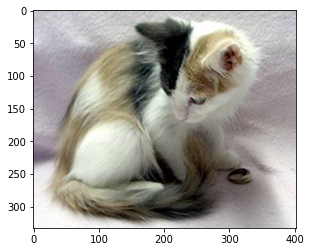

In [33]:
imagem = '/gato/cat.3500.jpg'
classificar_imagem(imagem)

Previsão:  0


'cachorro'

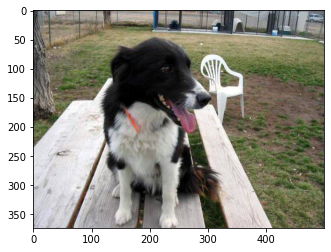

In [34]:
imagem = '/cachorro/dog.3502.jpg'
classificar_imagem(imagem)

Previsão:  0


'cachorro'

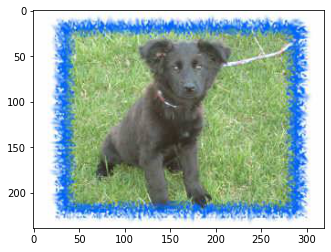

In [35]:
imagem = '/cachorro/dog.3505.jpg'
classificar_imagem(imagem)